# Algorithmic Trading using Machine Learning

**MS** **in** **Applied** **Data** **Science,** **University** **of** **Southern** **California**

Evaluation of the impact of polarity of news sentiment on "Apple" keyword on Stock Market Close Price using Feature Correlation Map, SelectKbest Features and Feature Importance Permutations.


In [1]:
#Importing Necessary Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Uploading the files to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Exploration**

In [3]:
#Loading the Necessary News Sentiment Files
Apple_stock=pd.read_csv('/content/drive/MyDrive/News Sentiment Data/AAPL.csv',index_col="Date",parse_dates=True)
Apple_stock.sort_index(inplace = True)
start=Apple_stock.index[0]
end=Apple_stock.index[-1]

In [4]:
#Lets have a look at the Apple Stock data
Apple_stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-20,1.031250,1.084821,1.013393,1.013393,0.872900,1831132800
2000-01-21,1.020089,1.020089,0.983817,0.993862,0.856077,495924800
2000-01-24,0.968192,1.006696,0.938616,0.948661,0.817142,440876800
2000-01-25,0.937500,1.010045,0.914063,1.002232,0.863286,497145600
2000-01-26,0.982143,1.019531,0.979911,0.983817,0.847424,367158400
...,...,...,...,...,...,...
2021-04-21,132.360001,133.750000,131.300003,133.500000,133.500000,68847100
2021-04-22,133.039993,134.149994,131.410004,131.940002,131.940002,84566500
2021-04-23,132.160004,135.119995,132.160004,134.320007,134.320007,78657500


**Preparing Stock Data For News Sentiments for "Apple" Keyword**




In [5]:
#Loading the Necessary News Sentiment Files
Apple=pd.read_csv('/content/drive/MyDrive/News Sentiment Data/news-sentiment-index_apple.csv',index_col="DateTime",parse_dates=True)
Apple.sort_index(inplace = True)

In [6]:
#Renaming the Columns of Data 
Apple = Apple.rename_axis('Date')
Apple.rename(columns = {"Index":"Sentiment"},inplace=True)
Apple.rename(columns = {"Count":"News Count"},inplace=True)

In [7]:
#Quick Look at Sentiment Data
Apple

,Sentiment,News Count
Date,,
2000-01-20,NaN,1
2000-01-21,NaN,1
2000-01-22,NaN,0
2000-01-23,NaN,0
2000-01-24,NaN,0
...,...,...
2021-04-24,-0.009375,42
2021-04-25,-0.030769,33
2021-04-26,-0.143478,34


Here, I want to show the impact of News Sentiment and Other Features of Stock on Predicting Close Price. Hence, We need to merge 2 dataset

In [8]:
#Merging 2 Dataset: Apple Stock Data and Apple News Sentiment Data
apple_merged = Apple.merge(Apple_stock, on='Date', how='left')
apple_merged

,Sentiment,News Count,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,
2000-01-20,NaN,1,1.031250,1.084821,1.013393,1.013393,0.872900,1.831133e+09
2000-01-21,NaN,1,1.020089,1.020089,0.983817,0.993862,0.856077,4.959248e+08
2000-01-22,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-23,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-24,NaN,0,0.968192,1.006696,0.938616,0.948661,0.817142,4.408768e+08
...,...,...,...,...,...,...,...,...
2021-04-24,-0.009375,42,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-25,-0.030769,33,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-26,-0.143478,34,134.830002,135.059998,133.559998,134.720001,134.720001,6.690510e+07


As the lenghth of 2 dataset is different, it will append null values at the dates when the stock market was close.
Hence, I created a dummy column which include 1 if Stock data is present else 0 when stock market is closed.

In [9]:
#Creating a Dummy List to Store and it will show '1' When the Stock Data was Present and '0' when there is NaN values
dummy_list = []
for i in apple_merged.index:
  if np.isnan(apple_merged['Open'][i]):
    dummy_list.append(0)
  else:
    dummy_list.append(1)

In [10]:
#Merged Apple Data
apple_merged['Stock Data Availability'] = dummy_list
apple_merged

,Sentiment,News Count,Open,High,Low,Close,Adj Close,Volume,Stock Data Availability
Date,,,,,,,,,
2000-01-20,NaN,1,1.031250,1.084821,1.013393,1.013393,0.872900,1.831133e+09,1
2000-01-21,NaN,1,1.020089,1.020089,0.983817,0.993862,0.856077,4.959248e+08,1
2000-01-22,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2000-01-23,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2000-01-24,NaN,0,0.968192,1.006696,0.938616,0.948661,0.817142,4.408768e+08,1
...,...,...,...,...,...,...,...,...,...
2021-04-24,-0.009375,42,NaN,NaN,NaN,NaN,NaN,NaN,0
2021-04-25,-0.030769,33,NaN,NaN,NaN,NaN,NaN,NaN,0
2021-04-26,-0.143478,34,134.830002,135.059998,133.559998,134.720001,134.720001,6.690510e+07,1


**Handling Null Values**

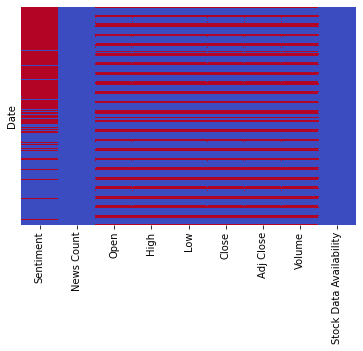

In [11]:
#Plotting the Heat Map to visualize the null values if present in the dataset.
sns.heatmap(apple_merged.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')


In [12]:
#Filling the NaN values of New Sentiment as '0' in dates when there are no news sentiments
apple_merged['Sentiment'] = apple_merged['Sentiment'].fillna(0)
apple_merged

,Sentiment,News Count,Open,High,Low,Close,Adj Close,Volume,Stock Data Availability
Date,,,,,,,,,
2000-01-20,0.000000,1,1.031250,1.084821,1.013393,1.013393,0.872900,1.831133e+09,1
2000-01-21,0.000000,1,1.020089,1.020089,0.983817,0.993862,0.856077,4.959248e+08,1
2000-01-22,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2000-01-23,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2000-01-24,0.000000,0,0.968192,1.006696,0.938616,0.948661,0.817142,4.408768e+08,1
...,...,...,...,...,...,...,...,...,...
2021-04-24,-0.009375,42,NaN,NaN,NaN,NaN,NaN,NaN,0
2021-04-25,-0.030769,33,NaN,NaN,NaN,NaN,NaN,NaN,0
2021-04-26,-0.143478,34,134.830002,135.059998,133.559998,134.720001,134.720001,6.690510e+07,1


In [13]:
#Filling the Null Values in Features using Forward Fill Method
for i in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    apple_merged[i].fillna(method='ffill', inplace=True)
apple_merged

,Sentiment,News Count,Open,High,Low,Close,Adj Close,Volume,Stock Data Availability
Date,,,,,,,,,
2000-01-20,0.000000,1,1.031250,1.084821,1.013393,1.013393,0.872900,1.831133e+09,1
2000-01-21,0.000000,1,1.020089,1.020089,0.983817,0.993862,0.856077,4.959248e+08,1
2000-01-22,0.000000,0,1.020089,1.020089,0.983817,0.993862,0.856077,4.959248e+08,0
2000-01-23,0.000000,0,1.020089,1.020089,0.983817,0.993862,0.856077,4.959248e+08,0
2000-01-24,0.000000,0,0.968192,1.006696,0.938616,0.948661,0.817142,4.408768e+08,1
...,...,...,...,...,...,...,...,...,...
2021-04-24,-0.009375,42,132.160004,135.119995,132.160004,134.320007,134.320007,7.865750e+07,0
2021-04-25,-0.030769,33,132.160004,135.119995,132.160004,134.320007,134.320007,7.865750e+07,0
2021-04-26,-0.143478,34,134.830002,135.059998,133.559998,134.720001,134.720001,6.690510e+07,1


**Feature Correlation**

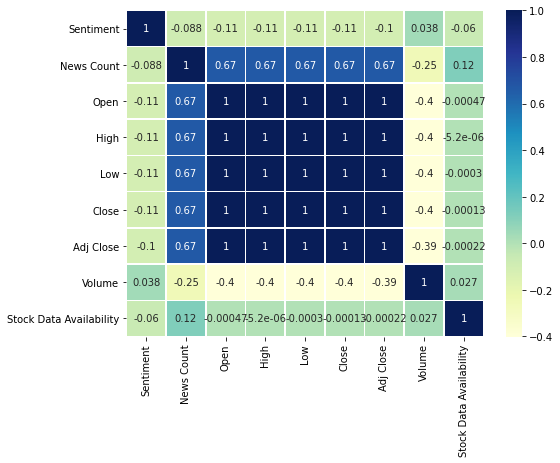

In [14]:
#Visualization of Correlation using Heat Map
import seaborn as sns
corrmat= apple_merged.corr()
top_features=corrmat.index
plt.figure(figsize=(8,6))
g=sns.heatmap(apple_merged[top_features].corr(), cmap='YlGnBu',annot=True,linewidths=.5)

## **Model Selection**

In [15]:
#First, we change the order of the features and we put the depedent variable at the star
features = ['Close','Sentiment', 'News Count', 'Stock Data Availability']

In [16]:
#Reset the order of Columns
apple_merged = apple_merged.reindex(columns = features ) 
apple_merged.head(1)

,Close,Sentiment,News Count,Stock Data Availability
Date,,,,
2000-01-20,1.013393,0.0,1,1


**Select-K-Best Features**

In [17]:
#Importing Necessary Libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [18]:
#Creating Select K-Best Function
def select_features(Xf_train, yf_train):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    # learn relationship from training data
    fs.fit(Xf_train, yf_train)
    return fs

In [19]:
#Taking Features W.R.T 'Close Price'
K_features= select_features(apple_merged[features[1:]],apple_merged['Close'])

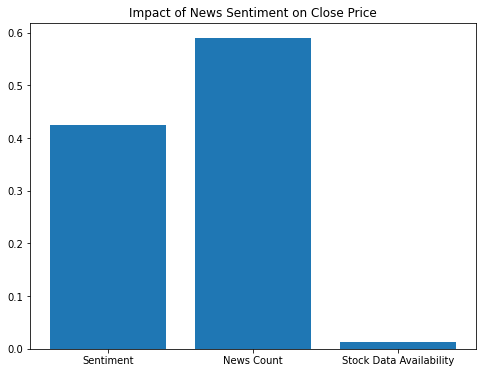

In [20]:
#Feature Importance Visualization
from matplotlib import pyplot
pyplot.figure(figsize=(8, 6))
pyplot.bar([i for i in features[1:]], K_features.scores_)
pyplot.title("Impact of News Sentiment on Close Price")
pyplot.show()

In [21]:
#Splitting the data into dependent and independent features
X=apple_merged.iloc[:,1:]
#Predicting the Close price of data
y=apple_merged.iloc[:,:1]

In [22]:
#Performing Test-Train-Valid Split in the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=43)

**RandomForestRegressor**

In [23]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Creating and Fitting the random forest model on Training Set of the data
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [24]:
# Predicting the stock price value for Apple Close Price using random forest model
pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)
pred_valid = rf.predict(X_val)

In [25]:
#Predicted Values on Test Data
pred_test

array([  3.71296805, 100.47999934,  62.82633469, ...,   3.71296805,
        26.80847071,   6.65718029])

## **Model Evaluation**

**Root Mean Squared Error**

In [26]:
# Using Root Mean Squared Error Metrics for Model Evaluation
from sklearn.metrics import mean_squared_error
train_RMSE = np.sqrt(mean_squared_error(y_train,pred_train))
test_RMSE = np.sqrt(mean_squared_error(y_test,pred_test))
val_RMSE = np.sqrt(mean_squared_error(y_val,pred_valid))

#Printing RMSE Values
train_RMSE, test_RMSE, val_RMSE

(12.556429203742999, 16.17528570948949, 16.696708710254455)

**Mean Absolute Error**

In [27]:
#Calculating Mean Absolute Error on Train, Val and Test Data
from sklearn.metrics import mean_absolute_error
train_MAE = mean_absolute_error(y_train, pred_train)
test_MAE = mean_absolute_error(y_test, pred_test)
val_MAE = mean_absolute_error(y_val, pred_valid)

#Printing MAE Values
train_MAE, test_MAE, val_MAE

(7.250682236660498, 9.796012054606889, 9.735478283842056)

In [28]:
#Creating the target vs prediction dataframe for each set of data for random forest model

train = pd.DataFrame()
train['target'] = y_train['Close']
train['predicted']=pred_train

test= pd.DataFrame()
test['target'] = y_test['Close']
test['predicted']=pred_test

In [29]:
#Train vs Predicted Close Price
train, test

(               target  predicted
 Date                            
 2001-12-24   0.381429   3.712968
 2011-06-15  11.669643   3.712968
 2005-05-24   1.417857   3.712968
 2015-08-06  28.782499  20.988972
 2000-02-27   0.985491   6.657180
 ...               ...        ...
 2017-01-12  29.812500  33.519025
 2006-06-02   2.202143   3.712968
 2006-05-11   2.433929   3.712968
 2009-05-04   4.716786   3.712968
 2016-05-11  23.127501  23.712617
 
 [5439 rows x 2 columns],                target   predicted
 Date                             
 2001-04-17   0.364286    3.712968
 2018-06-04  47.957500  100.479999
 2016-12-17  28.992500   62.826335
 2008-05-31   6.741071    6.657180
 2009-02-25   3.255714    3.712968
 ...               ...         ...
 2011-11-15  13.886786   25.258755
 2010-04-05   8.517500   30.127258
 2008-06-04   6.613929    3.712968
 2010-04-16   8.835714   26.808471
 2010-11-28  11.250000    6.657180
 
 [1166 rows x 2 columns])

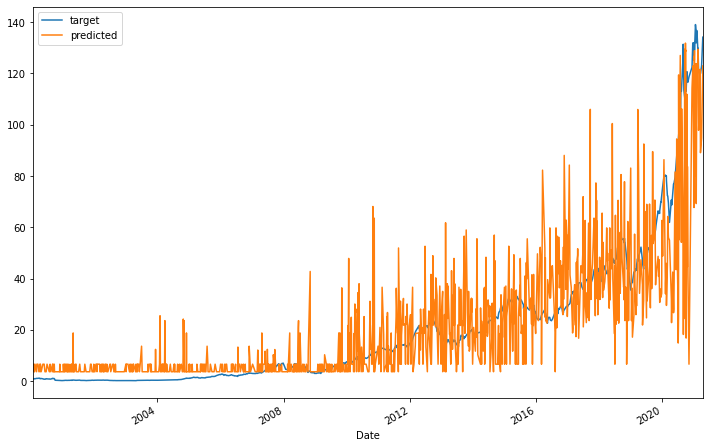

In [30]:
#Visualization of Train vs. Test Prediction
test[['target','predicted']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

**Feature Importance Permutation**

In [65]:
from sklearn.inspection import permutation_importance

#importance of each feature of News Sentiments Data 
col_list = X_train.columns
rfp = permutation_importance(rf,X_train, y_train,n_repeats=30,random_state=43)
print("Feature Importance Permutation of Close Price\n")
imp = []
std = []
cols = []
for i in rfp.importances_mean.argsort()[::-1]:
    if rfp.importances_mean[i] - 2 * rfp.importances_std[i] > 0:
        print(f"{col_list[i]:<8}\t\t"
              f"{rfp.importances_mean[i]:.3f}"
              f" +/- {rfp.importances_std[i]:.3f}")
        cols.append(col_list[i])
        imp.append(rfp.importances_mean[i])
        std.append(rfp.importances_std[i])

Feature Importance Permutation of Close Price

News Count		1.579 +/- 0.025
Stock Data Availability		0.168 +/- 0.009
Sentiment		0.159 +/- 0.004


In [66]:
#Permutation Importance
print("Permutation Importance:",imp)

Permutation Importance: [1.5792081612508537, 0.16764155777616077, 0.15922684251171024]


In [67]:
#Standard Deviation
print("Standard Deviation:",std)

Standard Deviation: [0.025409017412171195, 0.009065349513691128, 0.004469545142203481]


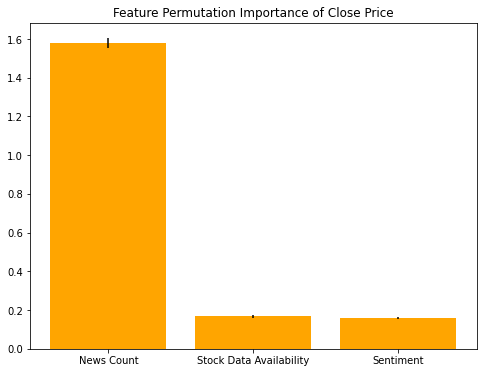

In [68]:
#Visualization of Feature Permutation Importance
plt.figure(figsize=(8, 6))
plt.title("Feature Permutation Importance of Close Price")
plt.bar(cols, imp, yerr=std, facecolor="orange")
plt.show()